 # Import Necessary Libraries

In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap

# Display settings
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the datasets

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Explainable AI Dataset/Data_Combined.xlsx')
df.head()

,Unnamed: 0,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Height,Waist_circumference,HB,...,Symp_Headache_i,breathlessness_i,taste_Smell_i,Close_to_Someonewith_Covid_i,break_through,sample_id,APOE2,APOE4,raw_APOE2,raw_APOE4
0,0,1,4,6,36,63,23,2,85,16,...,N,N,NaN,N,N,1,0,0,CC,TT
1,1,2,5,6,36,67,24,2,80,16,...,N,N,N,N,N,2,0,0,CC,TT
2,2,8,5,6,36,95,33,2,112,13,...,N,N,N,N,N,8,0,0,CC,TT
3,3,9,4,6,36,54,22,2,68,9,...,N,N,N,N,N,9,1,0,CT,TT
4,4,11,3,7,37,88,33,2,96,14,...,N,N,N,N,N,11,0,0,CC,TT


# Section 1. Data Filtering
Data (Data_combined.csv) filtered and remained with participants who were vaccinated with either Pfizer or J&J ONLY

In [ ]:
# Filter the dataset to include only participants vaccinated with Pfizer or J&J
filtered_data = df[(df['Vaccine_Type'] == 'Pfizer') | (df['Vaccine_Type'] == 'J&J')]
filtered_data

,Unnamed: 0,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Height,Waist_circumference,HB,...,Symp_Headache_i,breathlessness_i,taste_Smell_i,Close_to_Someonewith_Covid_i,break_through,sample_id,APOE2,APOE4,raw_APOE2,raw_APOE4
0,0,1,4,6,36,63,23,2,85,16,...,N,N,NaN,N,N,1,0,0,CC,TT
1,1,2,5,6,36,67,24,2,80,16,...,N,N,N,N,N,2,0,0,CC,TT
2,2,8,5,6,36,95,33,2,112,13,...,N,N,N,N,N,8,0,0,CC,TT
3,3,9,4,6,36,54,22,2,68,9,...,N,N,N,N,N,9,1,0,CT,TT
4,4,11,3,7,37,88,33,2,96,14,...,N,N,N,N,N,11,0,0,CC,TT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,248,706,5,4,36,92,38,2,103,14,...,N,NaN,N,N,N,706,0,2,CC,CC
249,249,707,17,6,36,73,30,2,93,15,...,N,N,N,N,N,707,0,0,CC,TT
252,252,710,7,6,36,80,31,2,106,13,...,N,N,N,N,N,710,1,0,CT,TT
253,253,712,5,6,36,44,19,2,76,12,...,N,N,N,N,N,712,0,2,CC,CC


# 3. Data Transformation

In [ ]:
# Import necessary libraries for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
# Identify numerical and categorical columns
num_attribs = filtered_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_attribs = filtered_data.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
filtered_data[cat_attribs] = filtered_data[cat_attribs].astype(str)  # Convert all values to strings

<ipython-input-31-a8ba3336fa97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[cat_attribs] = filtered_data[cat_attribs].astype(str)  # Convert all values to strings


In [ ]:
# Define pipelines for numerical and categorical attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

# Define the full pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

# Prepare the data (example: fit and transform)
clean_data = full_pipeline.fit_transform(filtered_data)

clean_data = pd.DataFrame(clean_data, columns=full_pipeline.get_feature_names_out())

# Check the transformed data
clean_data.head()

,num__Unnamed: 0,num__Patient_Number,num__Glucose_Level,num__Cholestrol,num__Temp,num__Weight,num__BMI,num__Height,num__Waist_circumference,num__HB,...,cat__Close_to_Someonewith_Covid_i_N,cat__Close_to_Someonewith_Covid_i_nan,cat__break_through_N,cat__break_through_Y,cat__raw_APOE2_CC,cat__raw_APOE2_CT,cat__raw_APOE2_TT,cat__raw_APOE4_CC,cat__raw_APOE4_TC,cat__raw_APOE4_TT
0,0.0,1.0,4.0,6.0,36.0,63.0,23.0,2.0,85.0,16.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,2.0,5.0,6.0,36.0,67.0,24.0,2.0,80.0,16.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.0,8.0,5.0,6.0,36.0,95.0,33.0,2.0,112.0,13.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3.0,9.0,4.0,6.0,36.0,54.0,22.0,2.0,68.0,9.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4.0,11.0,3.0,7.0,37.0,88.0,33.0,2.0,96.0,14.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
clean_data.columns = [
    col.replace('num__', '').replace('cat__', '') for col in clean_data.columns
]

In [ ]:
clean_data.columns.to_list()

['Unnamed: 0',
 'Patient_Number',
 'Glucose_Level',
 'Cholestrol',
 'Temp',
 'Weight',
 'BMI',
 'Height',
 'Waist_circumference',
 'HB',
 'Gender_x',
 'Age',
 'HLE',
 'Smoking',
 'Physical_activity',
 'PA/week',
 'PA level',
 'HPT',
 'Low/high_Blood_sugar',
 'Fam_hx_CVD',
 'High_Chol',
 'Kidney_problems',
 'Liver_problems',
 'Gender_y',
 'Participant_Number',
 'Age_of_Participant_b',
 'sample_id',
 'APOE2',
 'APOE4',
 'Vaccine_Type_J&J',
 'Vaccine_Type_Pfizer',
 'Vaccination_Status_Nill',
 'Vaccination_Status_complete',
 'Vaccination_Status_incomplete',
 'Number_of_Doses_1 Dose',
 'Number_of_Doses_1 Dose + 1 Booster',
 'Number_of_Doses_2 Doses',
 'Number_of_Doses_2 Doses + 1 Booster',
 'Number_of_Doses_2 Doses(both Pfizer) + 1 Booster',
 'Number_of_Doses_3 Doses + Booster',
 'Number_of_Doses_No',
 'Boosting_Status_Nill',
 'Boosting_Status_Not Boosted',
 'Boosting_Status_boosted',
 'Side_Effects_No',
 'Side_Effects_Yes',
 'Symptoms_and_Treatment_Nil',
 'Symptoms_and_Treatment_Yes',
 'Sy

# Section 2: Feature Engineering
#### 2.1 Augmenting Features
Combine related features into a single feature and drop the original columns

In [ ]:
# Define the groups of columns to combine
overall_health = ['Height', 'BP_Average_High Normal', 'BP_Average_Mild_Hypertension',
                  'BP_Average_Moderate_Hypertension', 'BP_Average_Normal', 'BP_Average_Optimal',
                  'BP_Average_Severe_Hypertension']

medical_history = ['HPT', 'High_Chol', 'Liver_problems', 'Kidney_problems', 'Low/high_Blood_sugar',
                   'COVID-19_comorbidities_N', 'COVID-19_comorbidities_Y', 'COVID-19_comorbidities_nan']

# Combine features by taking the mean of the group
clean_data['overall_health'] = clean_data[overall_health].sum(axis=1)
clean_data['medical_history'] = clean_data[medical_history].sum(axis=1)

# Drop the original columns
clean_data.drop(columns=overall_health, inplace=True)
clean_data.drop(columns=medical_history, inplace=True)

# Check the modified dataset
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Columns: 117 entries, Unnamed: 0 to medical_history
dtypes: float64(117)
memory usage: 142.7 KB


In [ ]:
clean_data.head()

,Unnamed: 0,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Waist_circumference,HB,Gender_x,...,break_through_N,break_through_Y,raw_APOE2_CC,raw_APOE2_CT,raw_APOE2_TT,raw_APOE4_CC,raw_APOE4_TC,raw_APOE4_TT,overall_health,medical_history
0,0.0,1.0,4.0,6.0,36.0,63.0,23.0,85.0,16.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,7.0
1,1.0,2.0,5.0,6.0,36.0,67.0,24.0,80.0,16.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,7.0
2,2.0,8.0,5.0,6.0,36.0,95.0,33.0,112.0,13.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,8.0
3,3.0,9.0,4.0,6.0,36.0,54.0,22.0,68.0,9.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0
4,4.0,11.0,3.0,7.0,37.0,88.0,33.0,96.0,14.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0


## Dropping Columns

In [ ]:
# Drop duplicates
duplicates = ['Participant_Number', ]

In [ ]:
clean_data.head()

,Unnamed: 0,Patient_Number,Glucose_Level,Cholestrol,Temp,Weight,BMI,Waist_circumference,HB,Gender_x,...,break_through_N,break_through_Y,raw_APOE2_CC,raw_APOE2_CT,raw_APOE2_TT,raw_APOE4_CC,raw_APOE4_TC,raw_APOE4_TT,overall_health,medical_history
0,0.0,1.0,4.0,6.0,36.0,63.0,23.0,85.0,16.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,7.0
1,1.0,2.0,5.0,6.0,36.0,67.0,24.0,80.0,16.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,7.0
2,2.0,8.0,5.0,6.0,36.0,95.0,33.0,112.0,13.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,8.0
3,3.0,9.0,4.0,6.0,36.0,54.0,22.0,68.0,9.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0
4,4.0,11.0,3.0,7.0,37.0,88.0,33.0,96.0,14.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0


In [ ]:
clean_data.columns.to_list()

['Unnamed: 0',
 'Patient_Number',
 'Glucose_Level',
 'Cholestrol',
 'Temp',
 'Weight',
 'BMI',
 'Waist_circumference',
 'HB',
 'Gender_x',
 'Age',
 'HLE',
 'Smoking',
 'Physical_activity',
 'PA/week',
 'PA level',
 'Fam_hx_CVD',
 'Gender_y',
 'Participant_Number',
 'Age_of_Participant_b',
 'sample_id',
 'APOE2',
 'APOE4',
 'Vaccine_Type_J&J',
 'Vaccine_Type_Pfizer',
 'Vaccination_Status_Nill',
 'Vaccination_Status_complete',
 'Vaccination_Status_incomplete',
 'Number_of_Doses_1 Dose',
 'Number_of_Doses_1 Dose + 1 Booster',
 'Number_of_Doses_2 Doses',
 'Number_of_Doses_2 Doses + 1 Booster',
 'Number_of_Doses_2 Doses(both Pfizer) + 1 Booster',
 'Number_of_Doses_3 Doses + Booster',
 'Number_of_Doses_No',
 'Boosting_Status_Nill',
 'Boosting_Status_Not Boosted',
 'Boosting_Status_boosted',
 'Side_Effects_No',
 'Side_Effects_Yes',
 'Symptoms_and_Treatment_Nil',
 'Symptoms_and_Treatment_Yes',
 'Symptoms_and_Treatment_nan',
 'Hospitalization_No',
 'Hospitalization_Yes',
 'Hospitalization_nan',

In [ ]:
# filtered_data.info()

In [ ]:
# Check for nulls in any column | Automation
dataset = filtered_data

no_nas = True
for col in dataset.columns:
    if dataset[col].isnull().any():
        print(f"There are nulls in: {col}")
        no_nas = False

if no_nas:
    print("Yup, all good no NAs in any column")

Yup, all good no NAs in any column


In [ ]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 0 to 256
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    156 non-null    int64 
 1   Patient_Number                156 non-null    int64 
 2   Glucose_Level                 156 non-null    int64 
 3   Cholestrol                    156 non-null    int64 
 4   Temp                          156 non-null    int64 
 5   Weight                        156 non-null    int64 
 6   BMI                           156 non-null    int64 
 7   Height                        156 non-null    int64 
 8   Waist_circumference           156 non-null    int64 
 9   HB                            156 non-null    int64 
 10  Gender_x                      156 non-null    int64 
 11  Age                           156 non-null    int64 
 12  HLE                           156 non-null    int64 
 13  Smoking                  

### Selecting relevant features for clustering

**Goal:** To identify profiles of individuals vaccinated with Pfizer or J&J and their relationship to breakthrough infections.

['Age', 'comorbidities', 'cardiovascular_risk_score', 'vaccine_status',
                   'HB', 'Glucose_Level', 'Cholestrol', 'Temp', 'BMI', 'Gender_x', 'Smoking',
                   'break_through']


In [ ]:
use_features = [
    'Weight', 'Waist_circumference', 'BMI', 'Weight_Category', 'Cholestrol',
    'Glucose_Level', 'Gender_x', 'Alcohol', 'Age', 'Marital_status',
    'break_through', 'Fam_hx_CVD', 'Side_Effects', 'PA/week', 'BP_Average',
    'Hazardous exposure', 'HB', 'High_Chol', 'HLE', 'Physical_activity',
    'Vaccination_Status', 'Vaccine_Type', 'Number_of_Doses', 'Smoking',
    'HPT', 'Symp_Headache', 'PA level', 'Low/high_Blood_sugar', 'Occupation', 'Co-Morbidities'
]

In [ ]:
len(use_features)

30

In [ ]:
# Check if features in use_features are present in filtered_data
for feat in use_features:
    if feat in filtered_data.columns:
        print(f"{feat}: YES!")
    else:
        print("_______" * 13)
        print(f"{feat}: NO!")


Weight: YES!
Waist_circumference: YES!
BMI: YES!
Weight_Category: YES!
Cholestrol: YES!
Glucose_Level: YES!
Gender_x: YES!
Alcohol: YES!
Age: YES!
Marital_status: YES!
break_through: YES!
Fam_hx_CVD: YES!
Side_Effects: YES!
PA/week: YES!
BP_Average: YES!
Hazardous exposure: YES!
HB: YES!
High_Chol: YES!
HLE: YES!
Physical_activity: YES!
Vaccination_Status: YES!
Vaccine_Type: YES!
Number_of_Doses: YES!
Smoking: YES!
HPT: YES!
Symp_Headache: YES!
PA level: YES!
Low/high_Blood_sugar: YES!
Occupation: YES!
Co-Morbidities: YES!


In [ ]:
# Drop columns that are not in use_features
filtered_data = filtered_data[use_features]

In [ ]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 0 to 256
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Weight                156 non-null    int64 
 1   Waist_circumference   156 non-null    int64 
 2   BMI                   156 non-null    int64 
 3   Weight_Category       156 non-null    object
 4   Cholestrol            156 non-null    int64 
 5   Glucose_Level         156 non-null    int64 
 6   Gender_x              156 non-null    int64 
 7   Alcohol               156 non-null    object
 8   Age                   156 non-null    int64 
 9   Marital_status        156 non-null    object
 10  break_through         156 non-null    object
 11  Fam_hx_CVD            156 non-null    int64 
 12  Side_Effects          156 non-null    object
 13  PA/week               156 non-null    int64 
 14  BP_Average            156 non-null    object
 15  Hazardous exposure    156 non-null    object


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
# Identify numerical and categorical columns
numerical_features = filtered_data.select_dtypes(include=['int64']).columns.tolist()
categorical_features = filtered_data.select_dtypes(include=['object']).columns.tolist()

# categorical_features = [
#     'Weight_Category', 'Gender_x', 'Alcohol', 'Marital_status',
#     'break_through', 'Fam_hx_CVD', 'Side_Effects', 'PA/week', 'Hazardous exposure',
#     'HLE', 'Physical_activity', 'Vaccination_Status', 'Vaccine_Type',
#     'Number_of_Doses', 'Smoking', 'HPT', 'Occupation'
# ]

# numerical_features = [
#     'Weight', 'Waist_circumference', 'BMI', 'Cholestrol', 'Glucose_Level', 'Age',
#     'BP_Average', 'HB', 'High_Chol', 'Symp_Headache', 'PA level',
#     'Low/high_Blood_sugar', 'Co-Morbidities'
# ]

# Define the transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(filtered_data)

# Create a DataFrame with the preprocessed data
preprocessed_columns = (
    numerical_features +
    list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
)

filtered_data = pd.DataFrame(X_preprocessed, columns=preprocessed_columns)

# Check the preprocessed data
filtered_data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 50 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Weight                                            156 non-null    float64
 1   Waist_circumference                               156 non-null    float64
 2   BMI                                               156 non-null    float64
 3   Cholestrol                                        156 non-null    float64
 4   Glucose_Level                                     156 non-null    float64
 5   Gender_x                                          156 non-null    float64
 6   Age                                               156 non-null    float64
 7   Fam_hx_CVD                                        156 non-null    float64
 8   PA/week                                           156 non-null    float64
 9   HB                   

# Number of Clusters

In [ ]:
# # Assuming filtered_data is your DataFrame
# for col in filtered_data.columns:
#     if filtered_data[col].dtype == 'object':
#         # Get dummies and drop the first column to avoid multicollinearity
#         dummies = pd.get_dummies(filtered_data[col], drop_first=True)
#         # Drop the original column from filtered_data
#         filtered_data.drop(col, axis=1, inplace=True)
#         # Concatenate the dummy variables with the original DataFrame
#         filtered_data = pd.concat([filtered_data, dummies], axis=1)

In [ ]:
# filtered_data.info()

In [ ]:
# for col in filtered_data.columns:
#     if filtered_data[col].dtype == 'bool':
#         filtered_data[col] = filtered_data[col].astype(int)

In [ ]:
# filtered_data.info()

In [ ]:
# Convert feature names to string
filtered_data.columns = filtered_data.columns.astype(str)

In [ ]:
# Determine the optimal number of clusters using the elbow method
wcss = []
range_clusters = range(1, 15)  # Adjust the range of clusters as needed
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(filtered_data)
    wcss.append(kmeans.inertia_)


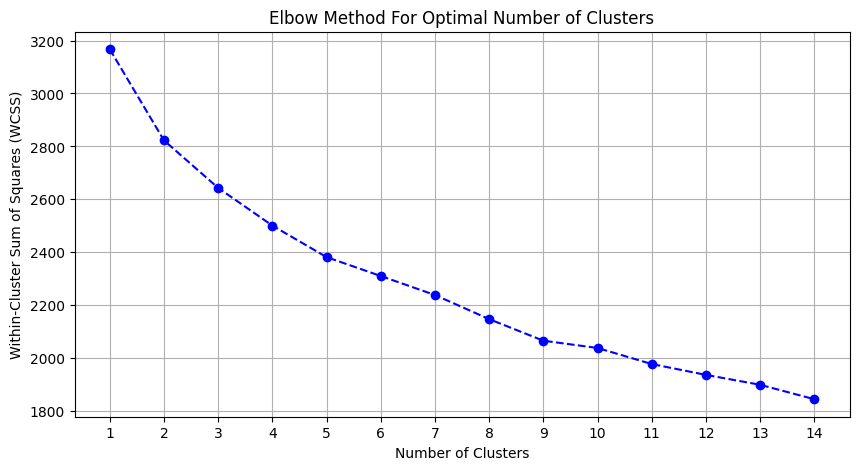

In [ ]:
# Plot the WCSS values
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

# Train the K-means algorithm

In [ ]:
# Train the K-means algorithm with the optimal number of clusters (assuming 3 from elbow method)
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(filtered_data)

In [ ]:
# Evaluate the model
sil_score = silhouette_score(filtered_data, clusters)
calinski_harabasz = calinski_harabasz_score(filtered_data, clusters)
# Adjusted Rand Index needs true labels, using clusters as a placeholder
ari = adjusted_rand_score(clusters, clusters)

print(f'Silhouette Score: {sil_score}')
print(f'Calinski-Harabasz Score: {calinski_harabasz}')
print(f'Adjusted Rand Index: {ari}')

Silhouette Score: 0.0813531840241415
Calinski-Harabasz Score: 12.45509860875042
Adjusted Rand Index: 1.0


## Silhouette Analysis: Compute Silhouette Scores for a Range of Cluster Numbers

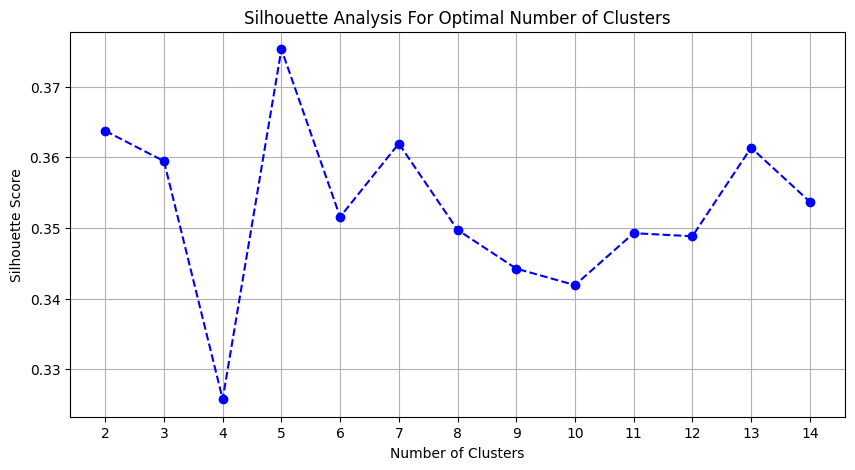

Best number of clusters: 5
Best Silhouette Score: 0.3752784494825177


In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)
pca_transformed_data = pca.fit_transform(filtered_data)

# Define the range of clusters to test
range_clusters = range(2, 15)

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(pca_transformed_data)
    sil_score = silhouette_score(pca_transformed_data, clusters)
    silhouette_scores.append(sil_score)

# Plot the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title('Silhouette Analysis For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

# Identify the best number of clusters
best_k = range_clusters[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f'Best number of clusters: {best_k}')
print(f'Best Silhouette Score: {best_score}')

## RANDOM FOREST CLASSIFIER

In [ ]:
# Add the cluster labels to the DataFrame
filtered_data['Cluster'] = clusters

# Drop the 'Cluster' column to create feature matrix X and target vector y
X = filtered_data.drop('Cluster', axis=1)
y = filtered_data['Cluster']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### SHAP Analysis (SHAPLEY)


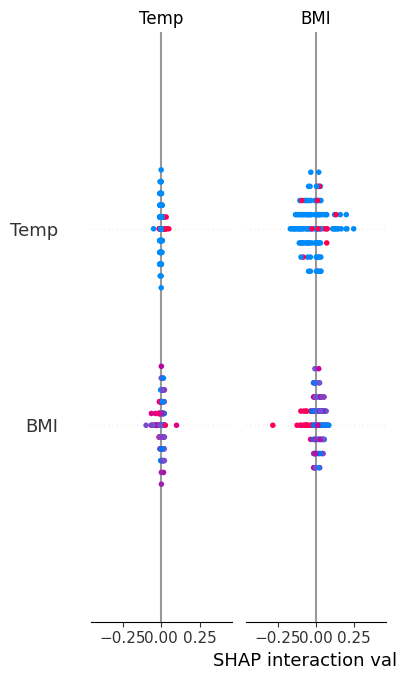

Most important features:
 [['BMI' 'Temp']
 ['Temp' 'BMI']
 ['Temp' 'BMI']
 ['Temp' 'BMI']
 ['BMI' 'Temp']
 ['Temp' 'BMI']
 ['BMI' 'Temp']
 ['Temp' 'BMI']]


In [ ]:
# Assuming rf is your trained RandomForestClassifier and X_train is your training data
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

# Get the most important features
shap_importances = np.abs(shap_values).mean(axis=0)
important_features = np.array(X_train.columns)[np.argsort(shap_importances)[-10:]]
print("Most important features:\n", important_features)

### Analyze and Visualize the Clusters

In [ ]:
# Analyze characteristics of each cluster
for cluster in range(optimal_clusters):
    print(f"Cluster {cluster} characteristics:")
    print(filtered_data[filtered_data['Cluster'] == cluster][important_features].mean())

# Visualize the clusters
for feature in important_features:
    plt.figure()
    for cluster in range(optimal_clusters):
        subset = filtered_data[filtered_data['Cluster'] == cluster]
        plt.hist(subset[feature], alpha=0.5, label=f'Cluster {cluster}')
    plt.title(f'Distribution of {feature} in Clusters')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()